# Checklist de base :

## Analyse de forme :
* **Variable cible** : `TARGET` : Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
* **Dimensions** : 307511 lignes 121 colonnes + 1 colonne ID Client
* Types de variables :
* Valeurs manquantes : les variables de type _AVG, _MODE, _MEDI sont très peu complètes.
OWN_CAR_AGE peu complète car la plupart des clients n'ont pas de voiture (soluce: -1)
EXT_SOURCE_1 très peu complète mais très utile malgré tout car c'est un score de qualité de l'emprunteur

In [1]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from styles import *

In [2]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv')
#test = pd.read_csv('../02_data/application_test.csv')
df = train.copy()

id_error_msg = lambda x: '`SK_ID_CURR` is not unic for {} set!'.format(x)
assert len(df.SK_ID_CURR.unique()) == df.shape[0], id_error_msg('train')
#assert len(test.SK_ID_CURR.unique()) == test.shape[0], id_error_msg('test')
df.set_index('SK_ID_CURR', inplace=True)
#test.set_index('SK_ID_CURR', inplace=True)

In [6]:
def format_categor_values(x):
    y = x.lower()
    y = y.replace(' ', '_')
    y = y.replace('-', '').replace(':', '')
    y = y.replace(',', '_or').replace('/', 'or')
    return y

In [7]:
dimensionality = lambda x,df : df[[x]].apply(pd.Series.nunique).values
categor_feats = df.select_dtypes('object').columns.tolist()
# Division entre les catégories dites "binaires" (les flags)
# et les catégories multi dimensionnelles
categor_ordinal_feats = []
categor_one_hot_feats = []
for feat in categor_feats:
    if dimensionality(feat,df) <= 2:
        categor_ordinal_feats.append(feat)
    elif dimensionality(feat,df) == 3 and 'XNA' in df[feat].unique():
        categor_ordinal_feats.append(feat)
    else:
        categor_one_hot_feats.append(feat)

df[categor_one_hot_feats]

,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
SK_ID_CURR,,,,,,,,
100002,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
100003,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
100004,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
100006,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
100007,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion
...,...,...,...,...,...,...,...,...
456251,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services
456252,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA
456253,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School


In [8]:
df[categor_one_hot_feats].isna().sum()

NAME_TYPE_SUITE                1292
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
OCCUPATION_TYPE               96391
WEEKDAY_APPR_PROCESS_START        0
ORGANIZATION_TYPE                 0
dtype: int64

In [18]:
df['ORGANIZATION_TYPE'].replace('xna','Unknown').unique()

array(['business_entity_type_3', 'school', 'government', 'religion',
       'other', 'Unknown', 'electricity', 'medicine',
       'business_entity_type_2', 'selfemployed', 'transport_type_2',
       'construction', 'housing', 'kindergarten', 'trade_type_7',
       'industry_type_11', 'military', 'services', 'security_ministries',
       'transport_type_4', 'industry_type_1', 'emergency', 'security',
       'trade_type_2', 'university', 'transport_type_3', 'police',
       'business_entity_type_1', 'postal', 'industry_type_4',
       'agriculture', 'restaurant', 'culture', 'hotel', 'industry_type_7',
       'trade_type_3', 'industry_type_3', 'bank', 'industry_type_9',
       'insurance', 'trade_type_6', 'industry_type_2', 'transport_type_1',
       'industry_type_12', 'mobile', 'trade_type_1', 'industry_type_5',
       'industry_type_10', 'legal_services', 'advertising',
       'trade_type_5', 'cleaning', 'industry_type_13', 'trade_type_4',
       'telecom', 'industry_type_8', 'realtor'

In [19]:
for col in df[categor_one_hot_feats]:
    df[col].fillna('Unknown', inplace=True)
    df[col].replace('xna', 'Unknown', inplace=True)
    df.loc[:, col] = df[col].astype(str).map(lambda x: format_categor_values(x))

pd.get_dummies(df[categor_one_hot_feats]).columns.tolist()

['NAME_TYPE_SUITE_children',
 'NAME_TYPE_SUITE_family',
 'NAME_TYPE_SUITE_group_of_people',
 'NAME_TYPE_SUITE_other_a',
 'NAME_TYPE_SUITE_other_b',
 'NAME_TYPE_SUITE_spouse_or_partner',
 'NAME_TYPE_SUITE_unaccompanied',
 'NAME_TYPE_SUITE_unknown',
 'NAME_INCOME_TYPE_businessman',
 'NAME_INCOME_TYPE_commercial_associate',
 'NAME_INCOME_TYPE_maternity_leave',
 'NAME_INCOME_TYPE_pensioner',
 'NAME_INCOME_TYPE_state_servant',
 'NAME_INCOME_TYPE_student',
 'NAME_INCOME_TYPE_unemployed',
 'NAME_INCOME_TYPE_working',
 'NAME_EDUCATION_TYPE_academic_degree',
 'NAME_EDUCATION_TYPE_higher_education',
 'NAME_EDUCATION_TYPE_incomplete_higher',
 'NAME_EDUCATION_TYPE_lower_secondary',
 'NAME_EDUCATION_TYPE_secondary_or_secondary_special',
 'NAME_FAMILY_STATUS_civil_marriage',
 'NAME_FAMILY_STATUS_married',
 'NAME_FAMILY_STATUS_separated',
 'NAME_FAMILY_STATUS_single_or_not_married',
 'NAME_FAMILY_STATUS_unknown',
 'NAME_FAMILY_STATUS_widow',
 'NAME_HOUSING_TYPE_coop_apartment',
 'NAME_HOUSING_TYPE_ho

In [49]:
df1 = train.copy()

In [51]:
df1.loc[df1.NAME_INCOME_TYPE == 'Unemployed']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
1156,101358,0,Revolving loans,F,N,N,0,337500.0,585000.0,29250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3937,104600,0,Revolving loans,F,N,Y,2,135000.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
23834,127729,1,Cash loans,F,N,Y,0,99000.0,783000.0,22306.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
35352,140949,0,Cash loans,F,N,N,0,56250.0,1530000.0,54954.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
37512,143454,1,Cash loans,M,Y,Y,0,31500.0,585000.0,26892.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
41723,148306,0,Revolving loans,F,N,Y,0,270000.0,135000.0,6750.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
77179,189489,0,Cash loans,F,N,N,1,54000.0,634500.0,23643.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
78336,190812,1,Cash loans,F,N,Y,0,45000.0,328500.0,10629.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
80704,193571,1,Cash loans,F,N,Y,0,90000.0,571500.0,20524.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
92061,206901,0,Revolving loans,M,Y,Y,0,270000.0,855000.0,42750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
pd.get_dummies(df[categor_one_hot_feats])

,NAME_TYPE_SUITE_children,NAME_TYPE_SUITE_family,NAME_TYPE_SUITE_group_of_people,NAME_TYPE_SUITE_other_a,NAME_TYPE_SUITE_other_b,NAME_TYPE_SUITE_spouse_or_partner,NAME_TYPE_SUITE_unaccompanied,NAME_TYPE_SUITE_unknown,NAME_INCOME_TYPE_businessman,NAME_INCOME_TYPE_commercial_associate,...,ORGANIZATION_TYPE_trade_type_4,ORGANIZATION_TYPE_trade_type_5,ORGANIZATION_TYPE_trade_type_6,ORGANIZATION_TYPE_trade_type_7,ORGANIZATION_TYPE_transport_type_1,ORGANIZATION_TYPE_transport_type_2,ORGANIZATION_TYPE_transport_type_3,ORGANIZATION_TYPE_transport_type_4,ORGANIZATION_TYPE_university,ORGANIZATION_TYPE_unknown
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100003,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100004,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100006,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100007,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
456252,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
456253,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
for col in df[categor_ordinal_feats]:
    df[col].replace('XNA', df[col].mode().values[0], inplace=True)

In [48]:
df['CODE_GENDER'].value_counts()

F    202452
M    105059
Name: CODE_GENDER, dtype: int64

In [37]:
df.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [31]:
print(df['CODE_GENDER'].mode().values[0])

F


In [13]:
df.select_dtypes(['object']).isna().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
dtype: int64

## Corrélations avec la variable cible

In [22]:
correlations = df.corr()['TARGET']

In [24]:
correlations = correlations.drop(['TARGET'], axis=0)
with pd.option_context('display.max_rows', None):
    print(correlations.sort_values(ascending=False))

DAYS_BIRTH                      0.078239
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_LAST_PHONE_CHANGE          0.055218
DAYS_ID_PUBLISH                 0.051457
REG_CITY_NOT_WORK_CITY          0.050994
FLAG_EMP_PHONE                  0.045982
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
DAYS_REGISTRATION               0.041975
LIVE_CITY_NOT_WORK_CITY         0.032518
DEF_30_CNT_SOCIAL_CIRCLE        0.032248
DEF_60_CNT_SOCIAL_CIRCLE        0.031276
FLAG_WORK_PHONE                 0.028524
AMT_REQ_CREDIT_BUREAU_YEAR      0.019930
CNT_CHILDREN                    0.019187
CNT_FAM_MEMBERS                 0.009308
OBS_30_CNT_SOCIAL_CIRCLE        0.009131
OBS_60_CNT_SOCIAL_CIRCLE        0.009022
REG_REGION_NOT_WORK_REGION      0.006942
REG_REGION_NOT_LIVE_REGION      0.005576
FLAG_DOCUMENT_2                 0.005417
FLAG_DOCUMENT_21                0.003709
LIVE_REGION_NOT_WORK_REGION     0.002819
AMT_REQ_CREDIT_B

# EDA avec prétraitement des données

In [6]:
from preprocessing import preprocessor
from preprocessing import get_preprocessed_set_column_names as get_col_names
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

preprocessor_scaler = Pipeline([('p', preprocessor), ('s', MinMaxScaler())])

df_trans = pd.DataFrame(preprocessor.fit_transform(df.iloc[:, 1:]),
                        columns=get_col_names(preprocessor))

df_trans_scl = pd.DataFrame(preprocessor_scaler.fit_transform(df.iloc[:, 1:]),
                            columns=get_col_names(preprocessor_scaler['p']))

In [7]:
df_trans

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,OWN_CAR_AGE,CNT_CHILDREN,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced_house,HOUSETYPE_MODE_unknown,WALLSMATERIAL_MODE_block,WALLSMATERIAL_MODE_mixed,WALLSMATERIAL_MODE_monolithic,WALLSMATERIAL_MODE_others,WALLSMATERIAL_MODE_panel,WALLSMATERIAL_MODE_stone_or_brick,WALLSMATERIAL_MODE_unknown,WALLSMATERIAL_MODE_wooden
0,406597.5,24700.5,351000.0,0.0,-1.0,0.0,202500.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1293502.5,35698.5,1129500.0,0.0,-1.0,0.0,270000.0,0.003541,-16765.0,-1188.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,135000.0,6750.0,135000.0,1.0,26.0,0.0,67500.0,0.010032,-19046.0,-225.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,312682.5,29686.5,297000.0,0.0,-1.0,0.0,135000.0,0.008019,-19005.0,-3039.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,513000.0,21865.5,513000.0,0.0,-1.0,0.0,121500.0,0.028663,-19932.0,-3038.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,254700.0,27558.0,225000.0,0.0,-1.0,0.0,157500.0,0.032561,-9327.0,-236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
307507,269550.0,12001.5,225000.0,0.0,-1.0,0.0,72000.0,0.025164,-20775.0,365243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
307508,677664.0,29979.0,585000.0,0.0,-1.0,0.0,153000.0,0.005002,-14966.0,-7921.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
307509,370107.0,20205.0,319500.0,0.0,-1.0,0.0,171000.0,0.005313,-11961.0,-4786.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
df_trans_scl

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,OWN_CAR_AGE,CNT_CHILDREN,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced_house,HOUSETYPE_MODE_unknown,WALLSMATERIAL_MODE_block,WALLSMATERIAL_MODE_mixed,WALLSMATERIAL_MODE_monolithic,WALLSMATERIAL_MODE_others,WALLSMATERIAL_MODE_panel,WALLSMATERIAL_MODE_stone_or_brick,WALLSMATERIAL_MODE_unknown,WALLSMATERIAL_MODE_wooden
0,0.090287,0.090032,0.077441,0.0,0.000000,0.0,0.001512,0.256321,0.888839,0.045086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.311736,0.132924,0.271605,0.0,0.000000,0.0,0.002089,0.045016,0.477114,0.043648,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.022472,0.020025,0.023569,1.0,0.293478,0.0,0.000358,0.134897,0.348534,0.046161,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.066837,0.109477,0.063973,0.0,0.000000,0.0,0.000935,0.107023,0.350846,0.038817,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.116854,0.078975,0.117845,0.0,0.000000,0.0,0.000819,0.392880,0.298591,0.038820,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.052360,0.101176,0.046016,0.0,0.000000,0.0,0.001127,0.446855,0.896392,0.046133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
307507,0.056067,0.040505,0.046016,0.0,0.000000,0.0,0.000396,0.344429,0.251071,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
307508,0.157969,0.110618,0.135802,0.0,0.000000,0.0,0.001089,0.065247,0.578523,0.026076,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
307509,0.081175,0.072499,0.069585,0.0,0.000000,0.0,0.001243,0.069553,0.747914,0.034258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
df_trans['TARGET'] = df['TARGET'].values
df_trans.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_unknown,WALLSMATERIAL_MODE_block,WALLSMATERIAL_MODE_mixed,WALLSMATERIAL_MODE_monolithic,WALLSMATERIAL_MODE_others,WALLSMATERIAL_MODE_panel,WALLSMATERIAL_MODE_stone_or_brick,WALLSMATERIAL_MODE_unknown,WALLSMATERIAL_MODE_wooden,TARGET
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [7]:
df_trans.iloc[:,:-1].head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced_house,HOUSETYPE_MODE_unknown,WALLSMATERIAL_MODE_block,WALLSMATERIAL_MODE_mixed,WALLSMATERIAL_MODE_monolithic,WALLSMATERIAL_MODE_others,WALLSMATERIAL_MODE_panel,WALLSMATERIAL_MODE_stone_or_brick,WALLSMATERIAL_MODE_unknown,WALLSMATERIAL_MODE_wooden
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
print(df.AMT_INCOME_TOTAL.describe())
print(df.AMT_INCOME_TOTAL.isnull().sum())

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
0


In [20]:
print(df.AMT_CREDIT.describe())
print(df.AMT_CREDIT.isnull().sum())

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64
0


In [21]:
print(df.AMT_ANNUITY.describe())
print(df.AMT_ANNUITY.isnull().sum())

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64
12


# Corrélations entre variables

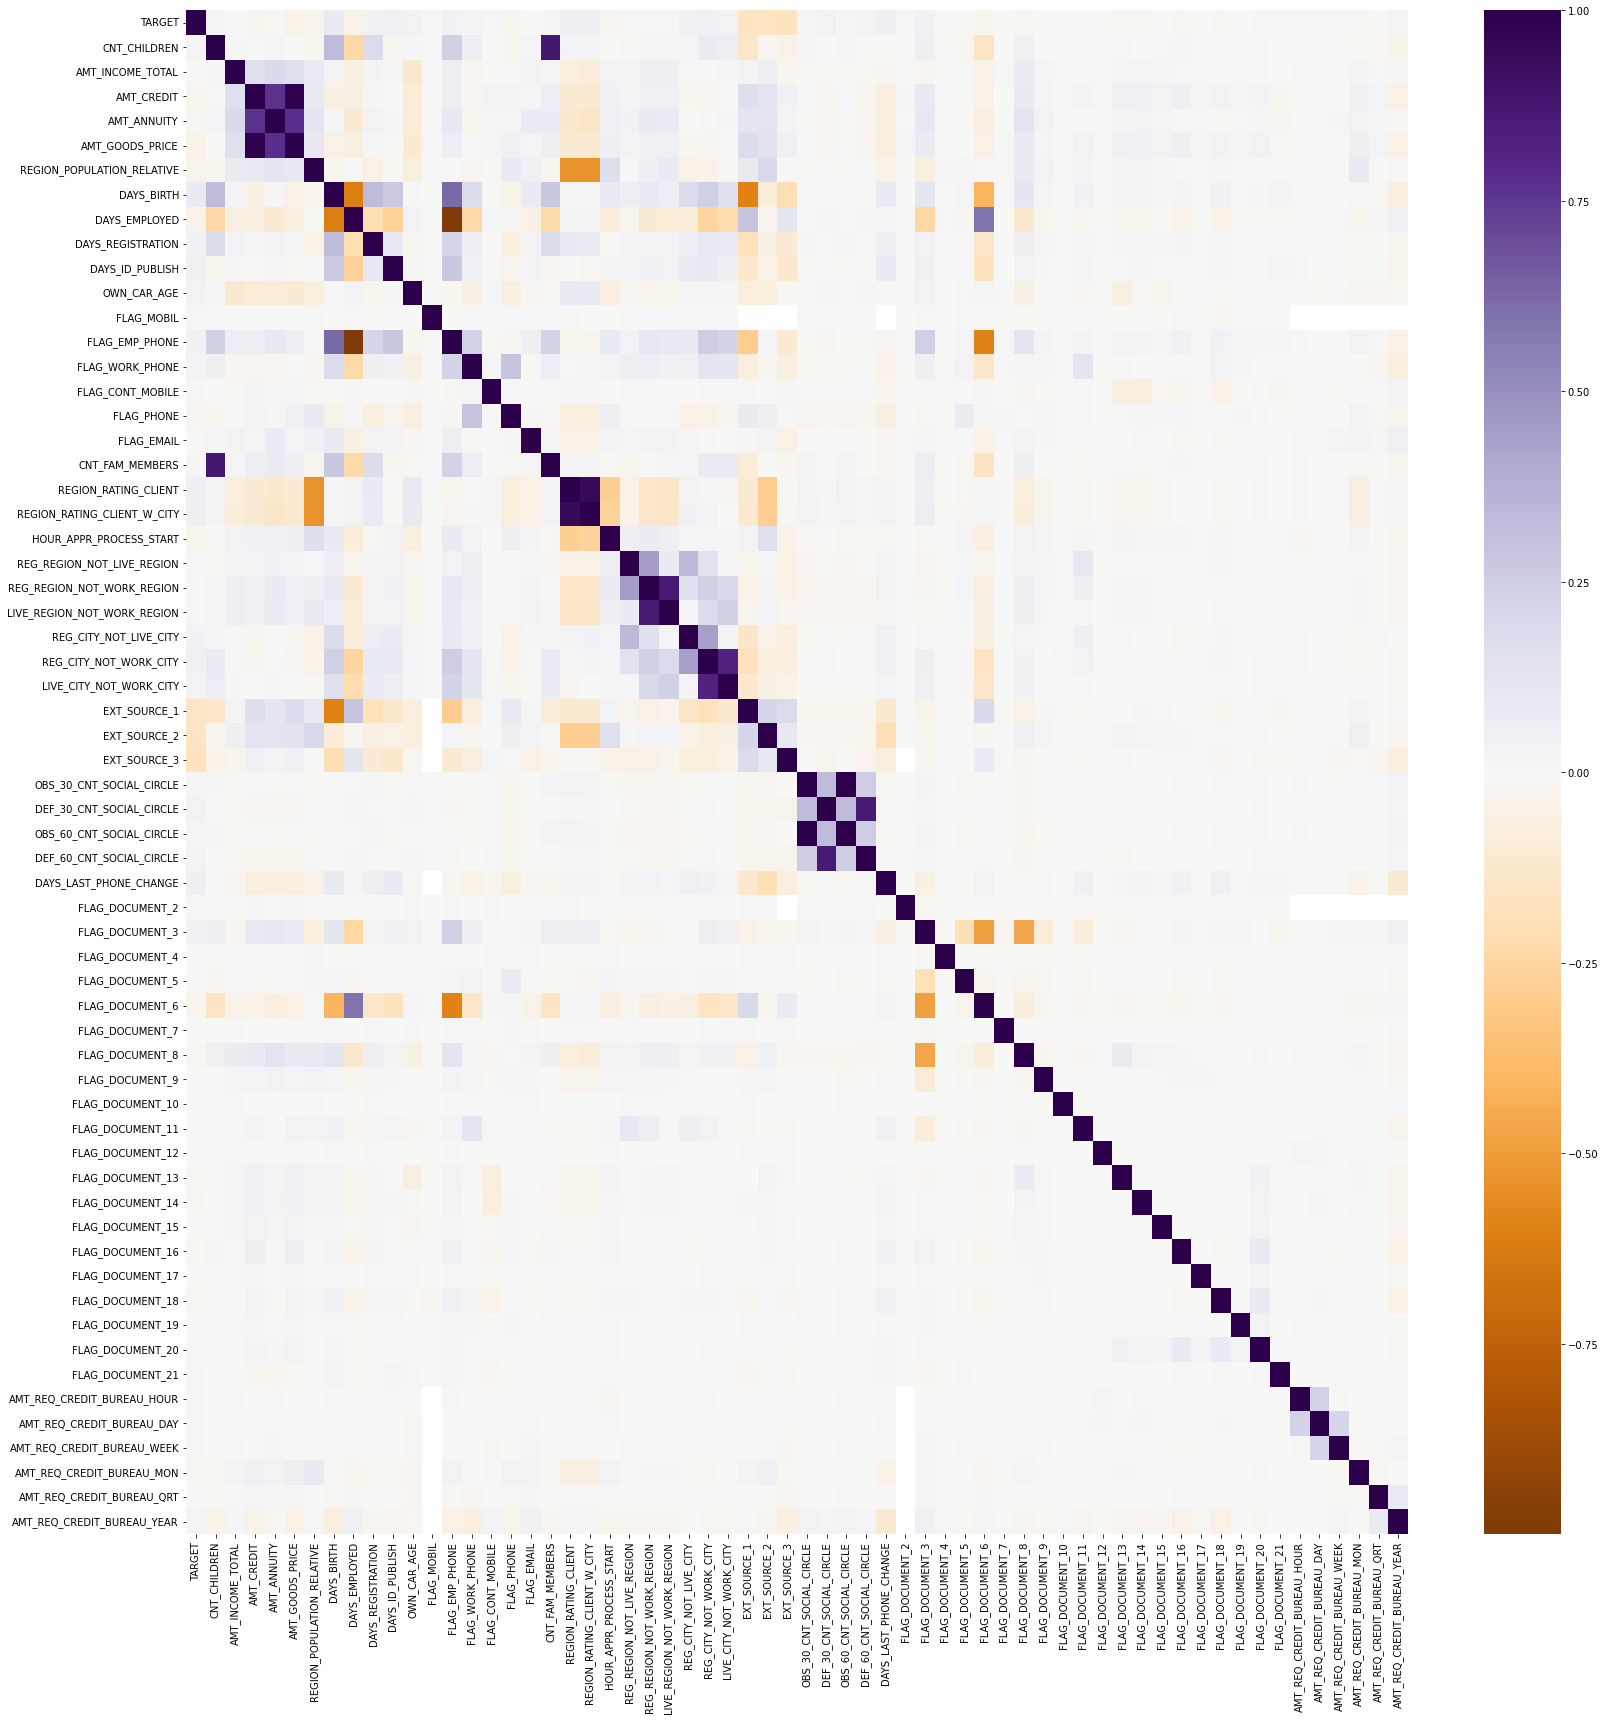

In [9]:
plt.figure(figsize=(24,24), facecolor='white')
sns.heatmap(df.corr(), cmap=plt.cm.PuOr)
plt.tight_layout()
plt.savefig('corr_heatmap_without_central_trend_feats.png')

In [6]:
# Find correlations with the target and sort
correlations = df_trans.corr()['TARGET'].sort_values()

In [7]:
correlations = correlations.drop(['TARGET'], axis=0)

In [25]:
abs_corr = correlations.apply(lambda x: np.abs(x)).sort_values(ascending=False)

In [27]:
with pd.option_context('display.max_rows', None):
    print(abs_corr)

EXT_SOURCE_3                    0.178919
EXT_SOURCE_2                    0.160472
EXT_SOURCE_1                    0.155317
DAYS_BIRTH                      0.078239
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_LAST_PHONE_CHANGE          0.055218
DAYS_ID_PUBLISH                 0.051457
REG_CITY_NOT_WORK_CITY          0.050994
FLAG_EMP_PHONE                  0.045982
DAYS_EMPLOYED                   0.044932
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
FLOORSMAX_AVG                   0.044003
FLOORSMAX_MEDI                  0.043768
FLOORSMAX_MODE                  0.043226
DAYS_REGISTRATION               0.041975
AMT_GOODS_PRICE                 0.039645
REGION_POPULATION_RELATIVE      0.037227
ELEVATORS_AVG                   0.034199
ELEVATORS_MEDI                  0.033863
FLOORSMIN_AVG                   0.033614
FLOORSMIN_MEDI                  0.033394
LIVINGAREA_AVG                  0.032997
LIVINGAREA_MEDI 

In [26]:
with pd.option_context('display.max_rows', None):
    print(abs_corr[abs_corr < 0.005])

FLAG_DOCUMENT_9                0.004352
FLAG_DOCUMENT_11               0.004229
AMT_INCOME_TOTAL               0.003982
FLAG_DOCUMENT_21               0.003709
FLAG_DOCUMENT_17               0.003378
NONLIVINGAPARTMENTS_AVG        0.003176
LIVE_REGION_NOT_WORK_REGION    0.002819
NONLIVINGAPARTMENTS_MEDI       0.002757
AMT_REQ_CREDIT_BUREAU_DAY      0.002704
FLAG_DOCUMENT_4                0.002672
AMT_REQ_CREDIT_BUREAU_QRT      0.002022
FLAG_EMAIL                     0.001758
NONLIVINGAPARTMENTS_MODE       0.001557
FLAG_DOCUMENT_7                0.001520
FLAG_DOCUMENT_10               0.001414
FLAG_DOCUMENT_19               0.001358
OWN_CAR_AGE                    0.001097
AMT_REQ_CREDIT_BUREAU_HOUR     0.000930
AMT_REQ_CREDIT_BUREAU_WEEK     0.000788
FLAG_DOCUMENT_12               0.000756
FLAG_MOBIL                     0.000534
FLAG_CONT_MOBILE               0.000370
FLAG_DOCUMENT_5                0.000316
FLAG_DOCUMENT_20               0.000215
Name: TARGET, dtype: float64


In [ ]:
# variables corrélées les unes aux autres, mat_corr
# tester importance features

In [12]:
print(correlations.apply(lambda x: np.abs(x))[-10:])

FLAG_EMP_PHONE                                        0.045982
NAME_EDUCATION_TYPE_secondary_or_secondary_special    0.049824
REG_CITY_NOT_WORK_CITY                                0.050994
DAYS_ID_PUBLISH                                       0.051457
DAYS_LAST_PHONE_CHANGE                                0.055218
NAME_INCOME_TYPE_working                              0.057481
REGION_RATING_CLIENT                                  0.058899
REGION_RATING_CLIENT_W_CITY                           0.060893
DAYS_BIRTH                                            0.078239
TARGET                                                1.000000
Name: TARGET, dtype: float64


In [4]:
X_scl = df_trans_scl.values
print(X_scl.var(axis=0))

[1.44448088e-03 4.10927498e-06 1.00996288e-02 3.19501489e-03
 8.48302708e-03 3.66802619e-02 6.05143786e-02 1.35951792e-01
 2.03885872e-02 4.39879059e-02 6.11355051e-03 2.29732128e-03
 6.47786679e-02 6.31859256e-02 2.01618632e-02 2.16194300e-02
 4.98358438e-02 3.80757059e-02 4.74986938e-05 1.72097226e-04
 4.77553478e-05 2.27172798e-04 3.71097209e-02 3.80386548e-04
 1.31069304e-04 5.68391061e-04 1.00702485e-03 8.12703842e-06
 4.98729896e-03 5.77010424e-03 2.81925431e-03 1.79644362e-03
 4.29907715e-03 1.74179461e-03 8.45836615e-03 4.96996966e-03
 1.05104363e-02 8.37328879e-03 2.67736984e-03 2.71206042e-03
 6.08858393e-03 6.96404921e-04 2.16638728e-03 6.10675729e-03
 2.83740315e-03 1.84126502e-03 4.20914420e-03 1.86596163e-03
 9.96210329e-03 5.03373350e-03 1.14485254e-02 8.54947983e-03
 2.82489877e-03 2.91948267e-03 6.56080992e-03 7.03071235e-04
 2.36292280e-03 5.96613858e-03 4.80891258e-03 2.16096979e-03
 5.16802782e-03 2.05083894e-03 9.55041684e-03 5.07587637e-03
 1.11487664e-02 8.435583

In [17]:
var_pct = ['{:.3g}%'.format(x*100) for x in X_scl.var(axis=0)]
for c,v in zip(df_trans.columns, var_pct):
    print(c, v)

CNT_CHILDREN 0.144%
AMT_INCOME_TOTAL 0.000411%
AMT_CREDIT 1.01%
AMT_ANNUITY 0.32%
AMT_GOODS_PRICE 0.848%
REGION_POPULATION_RELATIVE 3.67%
DAYS_BIRTH 6.05%
DAYS_EMPLOYED 13.6%
DAYS_REGISTRATION 2.04%
DAYS_ID_PUBLISH 4.4%
OWN_CAR_AGE 0.611%
CNT_FAM_MEMBERS 0.23%
REGION_RATING_CLIENT 6.48%
REGION_RATING_CLIENT_W_CITY 6.32%
HOUR_APPR_PROCESS_START 2.02%
EXT_SOURCE_1 2.16%
EXT_SOURCE_2 4.98%
EXT_SOURCE_3 3.81%
OBS_30_CNT_SOCIAL_CIRCLE 0.00475%
DEF_30_CNT_SOCIAL_CIRCLE 0.0172%
OBS_60_CNT_SOCIAL_CIRCLE 0.00478%
DEF_60_CNT_SOCIAL_CIRCLE 0.0227%
DAYS_LAST_PHONE_CHANGE 3.71%
AMT_REQ_CREDIT_BUREAU_HOUR 0.038%
AMT_REQ_CREDIT_BUREAU_DAY 0.0131%
AMT_REQ_CREDIT_BUREAU_WEEK 0.0568%
AMT_REQ_CREDIT_BUREAU_MON 0.101%
AMT_REQ_CREDIT_BUREAU_QRT 0.000813%
AMT_REQ_CREDIT_BUREAU_YEAR 0.499%
APARTMENTS_AVG 0.577%
BASEMENTAREA_AVG 0.282%
YEARS_BEGINEXPLUATATION_AVG 0.18%
YEARS_BUILD_AVG 0.43%
COMMONAREA_AVG 0.174%
ELEVATORS_AVG 0.846%
ENTRANCES_AVG 0.497%
FLOORSMAX_AVG 1.05%
FLOORSMIN_AVG 0.837%
LANDAREA_AVG 0.

# 2021-10-04 : Métrique de maximisation du profit

Il faut trouver une métrique qui approxime le profit que la banque fait sur un prêt remboursé et la perte que la banque encaisse en cas de défaut

In [78]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from styles import *

In [79]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
#test = pd.read_csv('../02_data/application_test.csv')

print('Training set dimensions :', train.shape)
df = train.copy()
df.head()

Training set dimensions : (307511, 121)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
from preprocessing import CreditInfosImputer

df = CreditInfosImputer().fit_transform(df)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
desc = pd.read_csv('../03_analysis/app_train_cols.tsv', sep='\t',
                   header=0, index_col=0)
desc.head()

,data_type,dimensionality,null_count,null_perct,description
name_col,,,,,
TARGET,int64,2.0,0,0.0,Target variable (1 - client with payment diffi...
NAME_CONTRACT_TYPE,object,2.0,0,0.0,Identification if loan is cash or revolving
CODE_GENDER,object,3.0,0,0.0,Gender of the client
FLAG_OWN_CAR,object,2.0,0,0.0,Flag if the client owns a car
FLAG_OWN_REALTY,object,2.0,0,0.0,Flag if client owns a house or flat


In [16]:
for col in ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'TARGET', 'NAME_CONTRACT_TYPE']:
    print(col, desc.loc[col, 'description'])

AMT_CREDIT Credit amount of the loan
AMT_ANNUITY Loan annuity
AMT_GOODS_PRICE For consumer loans it is the price of the goods for which the loan is given
TARGET Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
NAME_CONTRACT_TYPE Identification if loan is cash or revolving


In [60]:
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_INTEREST'] = \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_CREDIT'] - \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_GOODS_PRICE']
df.AMT_INTEREST.describe()

count    199041.000000
mean      94305.147927
std       66583.191590
min        2970.000000
25%       43479.000000
50%       80190.000000
75%      133650.000000
max      540000.000000
Name: AMT_INTEREST, dtype: float64

In [61]:
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'INTEREST_RATE'] = \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_INTEREST'] / \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_CREDIT']
df.INTEREST_RATE.describe()

count    199041.000000
mean          0.154437
std           0.065713
min           0.023208
25%           0.106185
50%           0.136740
75%           0.183275
max           0.833333
Name: INTEREST_RATE, dtype: float64

In [62]:
df.INTEREST_RATE.fillna(df.INTEREST_RATE.median(), inplace=True)
df.AMT_INTEREST.fillna(round(df.AMT_CREDIT * df.INTEREST_RATE, 0),
                       inplace=True)
print(df.INTEREST_RATE.describe())
print(df.AMT_INTEREST.describe())

count    307511.000000
mean          0.148195
std           0.053540
min           0.023208
25%           0.126790
50%           0.136740
75%           0.165275
max           0.833333
Name: INTEREST_RATE, dtype: float64
count    307511.000000
mean      87418.058130
std       62937.759157
min        2970.000000
25%       36920.000000
50%       71991.000000
75%      123066.000000
max      553798.000000
Name: AMT_INTEREST, dtype: float64


In [20]:
df.loc[df.AMT_GOODS_PRICE > df.AMT_CREDIT].NAME_CONTRACT_TYPE.value_counts()

0    247
1     13
Name: TARGET, dtype: int64

In [34]:
df.loc[:, 'INTEREST_RATE'] = df.AMT_INTERESTS / df.AMT_CREDIT
df.INTEREST_RATE.describe()

count    307511.000000
mean          0.099311
std           0.096587
min          -5.666667
25%           0.000000
50%           0.106185
75%           0.165275
max           0.833333
dtype: float64

In [42]:
df.loc[df.AMT_INTERESTS >= 0, 'INTEREST_RATE'].describe()

count    307251.000000
mean          0.100046
std           0.090769
min           0.000000
25%           0.000000
50%           0.106185
75%           0.165275
max           0.833333
Name: INTEREST_RATE, dtype: float64

In [69]:
df.loc[df.TARGET == 1, 'AMT_INTEREST'].sum()

2202850783.5

In [36]:
df.loc[df.TARGET == 1, 'AMT_INTEREST'].describe()

count     24825.000000
mean      69029.686949
std       69694.604633
min     -360000.000000
25%           0.000000
50%       57024.000000
75%      106920.000000
max      445500.000000
Name: AMT_INTEREST, dtype: float64

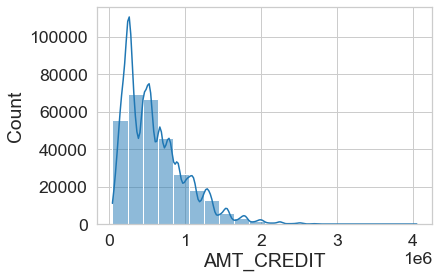

In [81]:
sns.histplot(data=df, x='AMT_CREDIT', bins=20, kde=True)
plt.show()

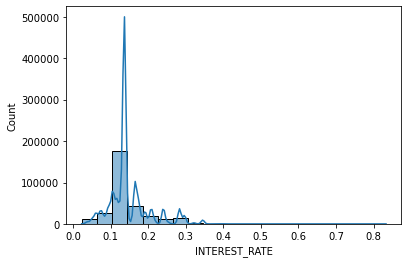

In [77]:
import seaborn as sns
sns.histplot(data=df, x='INTEREST_RATE', bins=20, kde=True)
plt.show()

In [7]:
df.NAME_CONTRACT_TYPE.value_counts(normalize=True)

Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64

# 2021-10-13 : Variables intéressantes sur le crédit

In [1]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from styles import *
from preprocessing import CreditInfosImputer

In [2]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
#test = pd.read_csv('../02_data/application_test.csv')

print('Training set dimensions :', train.shape)
df = train.copy()
df.head()

Training set dimensions : (307511, 121)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Taux d'intérêt

In [3]:
df = CreditInfosImputer().fit_transform(df)

# Création de la variable 'Somme des intérêts sur le crédit"
# Présupposés :
# . `AMT_GOODS_PRICE` est le montant du principal
# . `AMT_CREDIT` est la valeur totale du crédit, intérêts compris
# . Les entrées où `AMT_CREDIT` < `AMT_INTEREST` sont erronnées
# Construction :
#    `AMT_INTEREST` est la différence entre `AMT_CREDIT` et `AMT_GOODS_PRICE`
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_INTEREST'] = \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_CREDIT'] - \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_GOODS_PRICE']
print(df.AMT_INTEREST.describe())

# Création de la variable 'Taux d'intérêt sur le crédit"
# Construction :
# . `INTEREST_RATE` est la division de `AMT_INTEREST` par `AMT_CREDIT`
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'INTEREST_RATE'] = \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_INTEREST'] / \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_CREDIT']
print(df.INTEREST_RATE.describe())

count    199041.000000
mean      94305.147927
std       66583.191590
min        2970.000000
25%       43479.000000
50%       80190.000000
75%      133650.000000
max      540000.000000
Name: AMT_INTEREST, dtype: float64
count    199041.000000
mean          0.154437
std           0.065713
min           0.023208
25%           0.106185
50%           0.136740
75%           0.183275
max           0.833333
Name: INTEREST_RATE, dtype: float64


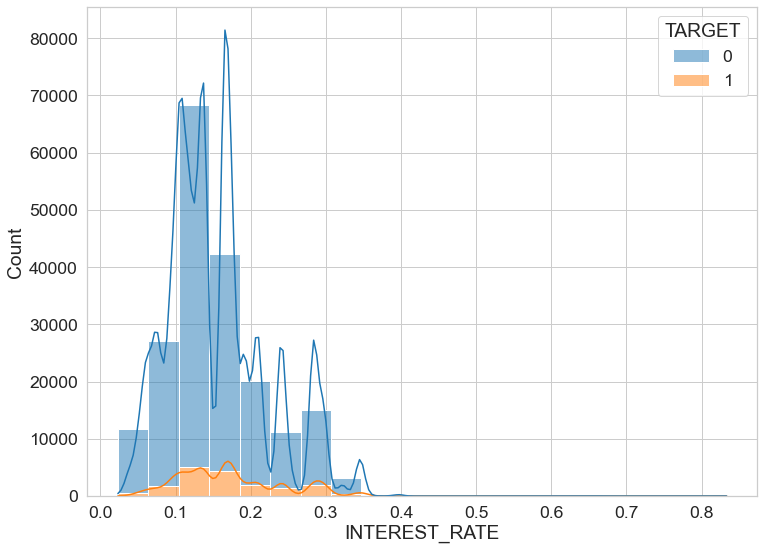

In [13]:
fig, ax = plt.subplots(figsize=(12,9))
sns.histplot(x='INTEREST_RATE', data=df, bins=20,
             hue='TARGET', multiple='stack', kde=True,
             ax=ax)
plt.show()

In [11]:
df.loc[df.INTEREST_RATE > .4, 'INTEREST_RATE'].shape

(31,)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.histplot(x='INTEREST_RATE', data=df, bins=20, hue='TARGET', ax=ax)
plt.show()

## Annuités et durée d'emprunt

In [14]:
print(df.AMT_ANNUITY.describe())

count    307511.000000
mean      27108.620161
std       14493.867117
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64


In [16]:
df.loc[:, 'CREDIT_PERIOD'] = df.loc[:, 'AMT_CREDIT'] / df.loc[:, 'AMT_ANNUITY']

In [17]:
df.CREDIT_PERIOD.describe()

count    307511.000000
mean         21.612259
std           7.823677
min           8.036674
25%          15.614555
50%          20.000000
75%          27.099985
max          45.305079
Name: CREDIT_PERIOD, dtype: float64

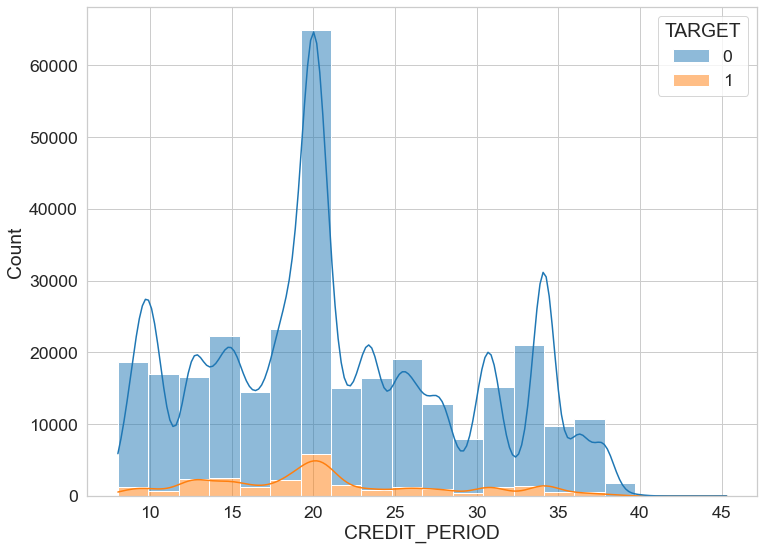

In [18]:
fig, ax = plt.subplots(figsize=(12,9))
sns.histplot(x='CREDIT_PERIOD', data=df, bins=20,
             hue='TARGET', multiple='stack', kde=True,
             ax=ax)
plt.show()

# 2021-10-13 : Autres variables intéressantes

## Age du client

In [24]:
df.loc[:, 'AGE'] = - df.loc[:, 'DAYS_BIRTH'] / 365.0
print(df.AGE.describe())

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: AGE, dtype: float64


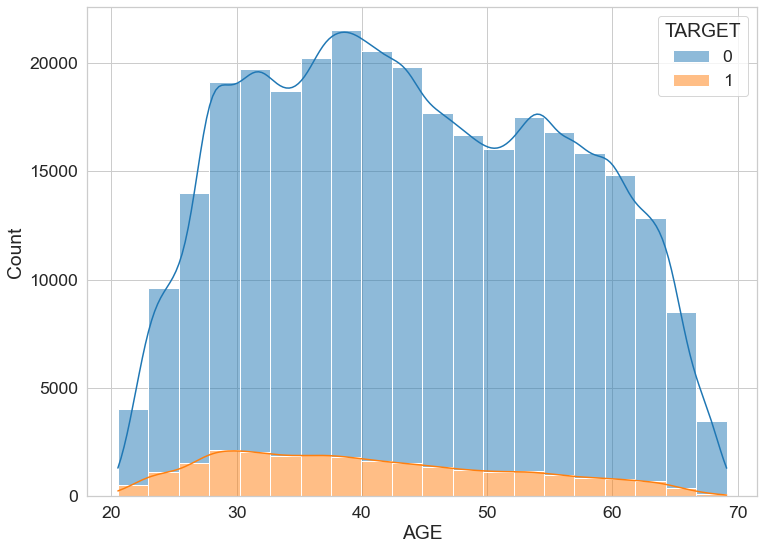

In [25]:
fig, ax = plt.subplots(figsize=(12,9))
sns.histplot(x='AGE', data=df, bins=20,
             hue='TARGET', multiple='stack', kde=True,
             ax=ax)
plt.show()

# 2021-10-20 : Exploration des autres tables

In [2]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from styles import *

In [4]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
test = pd.read_csv('../02_data/application_test.csv', index_col=0)
bureau = pd.read_csv('../02_data/bureau.csv')
bureau_bal = pd.read_csv('../02_data/bureau_balance.csv')

print('Training set dimensions :', train.shape)
df = train.copy()
df.head()

Training set dimensions : (307511, 121)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [7]:
buro_bal = pd.concat([bureau_bal, pd.get_dummies(bureau_bal.STATUS, 
                                                 prefix='bureau_bal_status')],
                     axis=1).drop('STATUS', axis=1)

In [8]:
buro_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,bureau_bal_status_0,bureau_bal_status_1,bureau_bal_status_2,bureau_bal_status_3,bureau_bal_status_4,bureau_bal_status_5,bureau_bal_status_C,bureau_bal_status_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0


In [9]:
buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
buro_counts

,MONTHS_BALANCE
SK_ID_BUREAU,
5001709,97
5001710,83
5001711,4
5001712,19
5001713,22
...,...
6842884,48
6842885,24
6842886,33


In [10]:
buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
buro_bal

,SK_ID_BUREAU,MONTHS_BALANCE,bureau_bal_status_0,bureau_bal_status_1,bureau_bal_status_2,bureau_bal_status_3,bureau_bal_status_4,bureau_bal_status_5,bureau_bal_status_C,bureau_bal_status_X,buro_count
0,5715448,0,0,0,0,0,0,0,1,0,27
1,5715448,-1,0,0,0,0,0,0,1,0,27
2,5715448,-2,0,0,0,0,0,0,1,0,27
3,5715448,-3,0,0,0,0,0,0,1,0,27
4,5715448,-4,0,0,0,0,0,0,1,0,27
...,...,...,...,...,...,...,...,...,...,...,...
27299920,5041336,-47,0,0,0,0,0,0,0,1,24
27299921,5041336,-48,0,0,0,0,0,0,0,1,24
27299922,5041336,-49,0,0,0,0,0,0,0,1,24
27299923,5041336,-50,0,0,0,0,0,0,0,1,24


In [11]:
avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()

In [12]:
avg_buro_bal

,MONTHS_BALANCE,bureau_bal_status_0,bureau_bal_status_1,bureau_bal_status_2,bureau_bal_status_3,bureau_bal_status_4,bureau_bal_status_5,bureau_bal_status_C,bureau_bal_status_X,buro_count
SK_ID_BUREAU,,,,,,,,,,
5001709,-48.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.886598,0.113402,97.0
5001710,-41.0,0.060241,0.000000,0.0,0.0,0.0,0.0,0.578313,0.361446,83.0
5001711,-1.5,0.750000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.250000,4.0
5001712,-9.0,0.526316,0.000000,0.0,0.0,0.0,0.0,0.473684,0.000000,19.0
5001713,-10.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,22.0
...,...,...,...,...,...,...,...,...,...,...
6842884,-23.5,0.187500,0.000000,0.0,0.0,0.0,0.0,0.416667,0.395833,48.0
6842885,-11.5,0.500000,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000,24.0
6842886,-16.0,0.242424,0.000000,0.0,0.0,0.0,0.0,0.757576,0.000000,33.0
